# Micronuclei detection
 Automated pipeline to process images. Further details will be add [here](www...)

 This includes
 - predict counts of micronuclei
 - predict masks
 - output a info dictionary with box, center location and size

# set up

In [1]:
using_colab = True

In [2]:
if using_colab:
  !cp /content/drive/MyDrive/PMCC/models/RCNN.pt RCNN.pt

  %cd /content/
  !git clone https://github.com/kew6688/MicroNuclei_Detection.git
  !pip install -e MicroNuclei_Detection/.
  !pip show mn_segmentation
  %cd /content/MicroNuclei_Detection

cp: cannot stat '/content/drive/MyDrive/PMCC/models/RCNN.pt': No such file or directory
/content
Cloning into 'MicroNuclei_Detection'...
remote: Enumerating objects: 321, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (12/12), done.
remote: Total 321 (delta 1), reused 5 (delta 0), pack-reused 308 (from 1)
Receiving objects: 100% (321/321), 23.75 MiB | 14.25 MiB/s, done.
Resolving deltas: 100% (168/168), done.
Obtaining file:///content/MicroNuclei_Detection
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for mn_segmentation (pyproject.toml) ... done
  Created wheel for mn_segmentation: filename=mn_segmentation-0.1.0-py2.py3-none-any.whl size=997 sha256=f6cb80e271d70cc0be3756500aad5bc1cb50c3f33f1176e9bd7e90af571d5d05
  Stored in directory: /tmp/pip-ephem-wheel-cache-5bc081

In [3]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

from mn_segmentation.lib.Application import Application
from mn_segmentation.lib.image_crop import show_crop_windows

# Example image

The image is processed in tiles, using ```show_crop_window``` to display how the image is cropped.


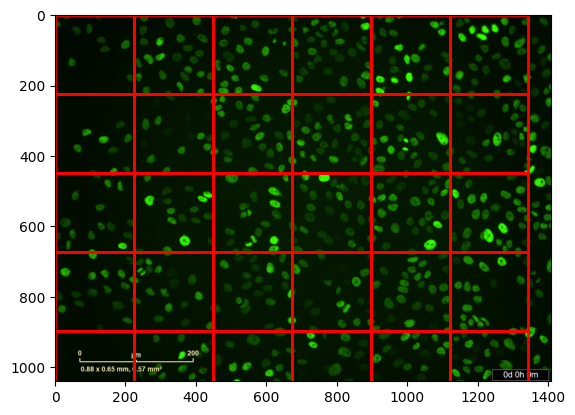

In [4]:
# Load an image using PIL
image_path = 'sample_images/example.tif'
show_crop_windows(image_path=image_path, n_wnd=30, row=5, box_sz=(224,224), stride=(224,224))

# Load model

In [ ]:
model = Application("/content/RCNN.pt")

# Predict mask

predict a mask with all micronuclei pridicted with unique ID from 1 to n. The mask has the same shape to the image.

In [10]:
mask = model.predict_image_mask(image_path)

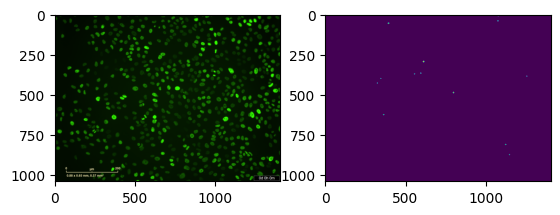

In [11]:
fig, ax = plt.subplots(1,2)
img = Image.open(image_path)
ax[0].imshow(img)
ax[1].imshow(mask>0)
plt.show()

Seperate the mask into isolate micronuclei mask

In [14]:
obj_ids = np.unique(mask)
masks = (mask == obj_ids[:, None, None])
print(masks.shape)  # shape [n,w,h], n is the number of masks

(14, 1040, 1408)


# Predict count

count the number of micronuclei inside one image

In [15]:
cnt = model.predict_image_count(image_path)
print(cnt)

25


# Predict info
each image will return a mn_info dict.
```
mn_info:
{
      "coord": [[x1, y1],...],   `# list of center coordinates
      "area": [x,...],        # list of mask area
      "bbox": [...],         # list of bounding box,
                        for mn bbox: (xmin, ymin, xmax, ymax)
                        for nuc bbox: (x, y, w, h)
}
```

In [16]:
mn_info = model.predict_image_info(image_path)
print(mn_info)

{'coord': [[395, 56], [272, 116], [785, 53], [1076, 41], [1079, 9], [931, 209], [1328, 60], [347, 400], [326, 429], [614, 295], [557, 372], [596, 368], [720, 406], [880, 401], [1096, 371], [994, 357], [1257, 385], [137, 537], [63, 501], [364, 626], [539, 647], [800, 488], [1346, 582], [1011, 816], [1026, 812], [1124, 811], [1149, 874]], 'area': [55.67295455932617, 23.098928451538086, 21.068702697753906, 33.76253128051758, 37.56330871582031, 90.95879364013672, 24.28789520263672, 19.968795776367188, 21.512632369995117, 64.978759765625, 24.38471794128418, 28.831409454345703, 26.033824920654297, 31.353179931640625, 25.38457679748535, 161.13140869140625, 20.514442443847656, 17.28468132019043, 87.74317932128906, 34.778160095214844, 28.79364776611328, 53.12850570678711, 56.792972564697266, 17.103240966796875, 21.297353744506836, 33.34770202636719, 23.812341690063477], 'bbox': [[391, 53, 399, 60], [270, 114, 274, 118], [783, 51, 787, 55], [1074, 39, 1079, 44], [1076, 6, 1082, 12], [926, 204, 9